In [145]:
from dariah_topics import preprocessing as pre
from dariah_topics import visualization as visual
from dariah_topics import evaluation

## Preprocessing

#### Liste mit Dateinamen erzeugen

In [146]:
#path_txt = "corpus_txt"
path_txt = "grenzbote_plain/*/"

doclist_txt = pre.create_document_list(path_txt)
assert doclist_txt, "No documents found"
doclist_txt[:5]

['grenzbote_plain\\Jg_26_1867\\1867_Abseit_der_Heerstraße_43.txt',
 'grenzbote_plain\\Jg_26_1867\\1867_Alt_Mecklenburg_auf_dem_Rückzuge_60.txt',
 'grenzbote_plain\\Jg_26_1867\\1867_Anfang_und_Ende_des_mexikanischen_Kaiserreichs_59.txt',
 'grenzbote_plain\\Jg_26_1867\\1867_Aus_dem_Musikleben_Wiens_32.txt',
 'grenzbote_plain\\Jg_26_1867\\1867_Aus_der_Provinz_Preußen_45.txt']

#####  Liste mit Dokumentenlabels erzeugen - (Funktion wird durch Thorsten's generischere Funktion ersetzt)

In [149]:
doc_labels = list(pre.get_labels(doclist_txt))
doc_labels[:5]

['grenzbote_plain\\Jg_26_1867\\1867_Abseit_der_Heerstraße_43.txt',
 'grenzbote_plain\\Jg_26_1867\\1867_Alt_Mecklenburg_auf_dem_Rückzuge_60.txt',
 'grenzbote_plain\\Jg_26_1867\\1867_Anfang_und_Ende_des_mexikanischen_Kaiserreichs_59.txt',
 'grenzbote_plain\\Jg_26_1867\\1867_Aus_dem_Musikleben_Wiens_32.txt',
 'grenzbote_plain\\Jg_26_1867\\1867_Aus_der_Provinz_Preußen_45.txt']

#### Corpus laden

In [150]:
corpus_txt = pre.read_from_txt(doclist_txt)

#### Tokenisieren

In [153]:
doc_tokens = [list(pre.tokenize(txt)) for txt in list(corpus_txt)]

#### Create Dictionaries

In [157]:
id_types, doc_ids = pre.create_dictionaries(doc_labels, doc_tokens)

#### Sparse BOW Model

In [158]:
sparse_bow = pre.create_mm(doc_labels, doc_tokens, id_types, doc_ids)

In [159]:
sparse_bow[:5]

0
doc_id token_id    
1      69632     29
       94209      1
       16386      1
       32771      1
       77828      2

## Topic Modeling with Gensim

##### Saving Sparse BOW

In [168]:
pre.save_bow_mm(sparse_bow)

#### Import Market Matrix

In [169]:
from gensim.models import LdaModel
from gensim.corpora import MmCorpus

In [170]:
mm = MmCorpus("gb_plain.mm")

In [175]:
doc2id = {value : key for key, value in doc_ids.items()}
type2id = {value : key for key, value in id_types.items()}

##### Remove Features

In [ ]:
import os.path
basepath = os.path.abspath('.')

with open(os.path.join(basepath, "tutorial_supplementals", "stopwords", "de.txt"), 'r', encoding = 'utf-8') as f: 
    stopword_list = f.read().split('\n')
    
stopword_list = set(stopword_list)

In [177]:
hapax_from_remove = pre.find_hapax(sparse_bow, id_types)
stopwords_from_remove = set(pre.find_stopwords(sparse_bow, id_types))

features_to_be_removed = hapax_from_remove.union(set(stopword_list))

sparse_bow_short = pre.remove_features(sparse_bow, id_types,features_to_be_removed)

#### Convert sparse_bow to list of (doc, tokens) tuples (like doc2bow)

In [178]:
doc2bow_list = []

for doc in sparse_bow_short.index.groupby(sparse_bow_short.index.get_level_values('doc_id')):
    temp = [(token, count) for token, count in zip(sparse_bow_short.loc[doc].index, sparse_bow_short.loc[doc][0])]
    doc2bow_list.append(temp)

In [179]:
len(doc2bow_list)

363

In [180]:
#model = LdaModel(corpus=mm, id2word=type2id, num_topics=60, alpha = "symmetric", passes = 10) #import momentan in visual 
# -> da ich mir noch nicht sicher bin, welche Funktionen in das tm_gensim.py sollen
model = LdaModel(corpus=doc2bow_list, id2word=type2id, num_topics=20, passes = 100, iterations = 20)

In [181]:
model.get_document_topics(doc2bow_list[1])

[(13, 0.97934782608491966)]

In [182]:
#Anzeige der keywords für topic n
n = 1
topic_nr_x = model.get_topic_terms(n)

topicTerms = [type2id[i[0]] for i in topic_nr_x]
topicTerms

['udschidschi',
 'livingstone',
 'deggendorf',
 'seyn',
 'sansibar',
 'wucher',
 'vorjahr',
 'judenverfolgungen',
 'karavane',
 'bagamojo']

In [209]:
#Topic probabilities
topics = model.show_topics(num_topics = 40)
topics

'0.006*"azeglio" + 0.005*"bergung" + 0.004*"bergelohn" + 0.003*"gestrandeten" + 0.002*"strandrecht" + 0.002*"greeley" + 0.002*"waldecksche" + 0.002*"napoleon\'s" + 0.002*"alfieri" + 0.002*"azeglios"'

from scipy.io import mmread
test = mmread("gb_plain.mm")
import pandas as pd
pd.DataFrame(test.data)

## Visualisierung 

In [192]:
'''lda_model = 'out_easy/corpus.lda'
corpus = 'out_easy/corpus.mm'
dictionary = 'out_easy/corpus.dict'
doc_labels = 'out_easy/corpus_doclabels.txt'
interactive  = False

vis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)'''

"lda_model = 'out_easy/corpus.lda'\ncorpus = 'out_easy/corpus.mm'\ndictionary = 'out_easy/corpus.dict'\ndoc_labels = 'out_easy/corpus_doclabels.txt'\ninteractive  = False\n\nvis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)"

##### Create a document-topic matrix (that is a pandas data frame actually)

In [193]:
doc_topic = visual.create_doc_topic(mm, model, doc_labels)

##### Visualize document-topic matrix

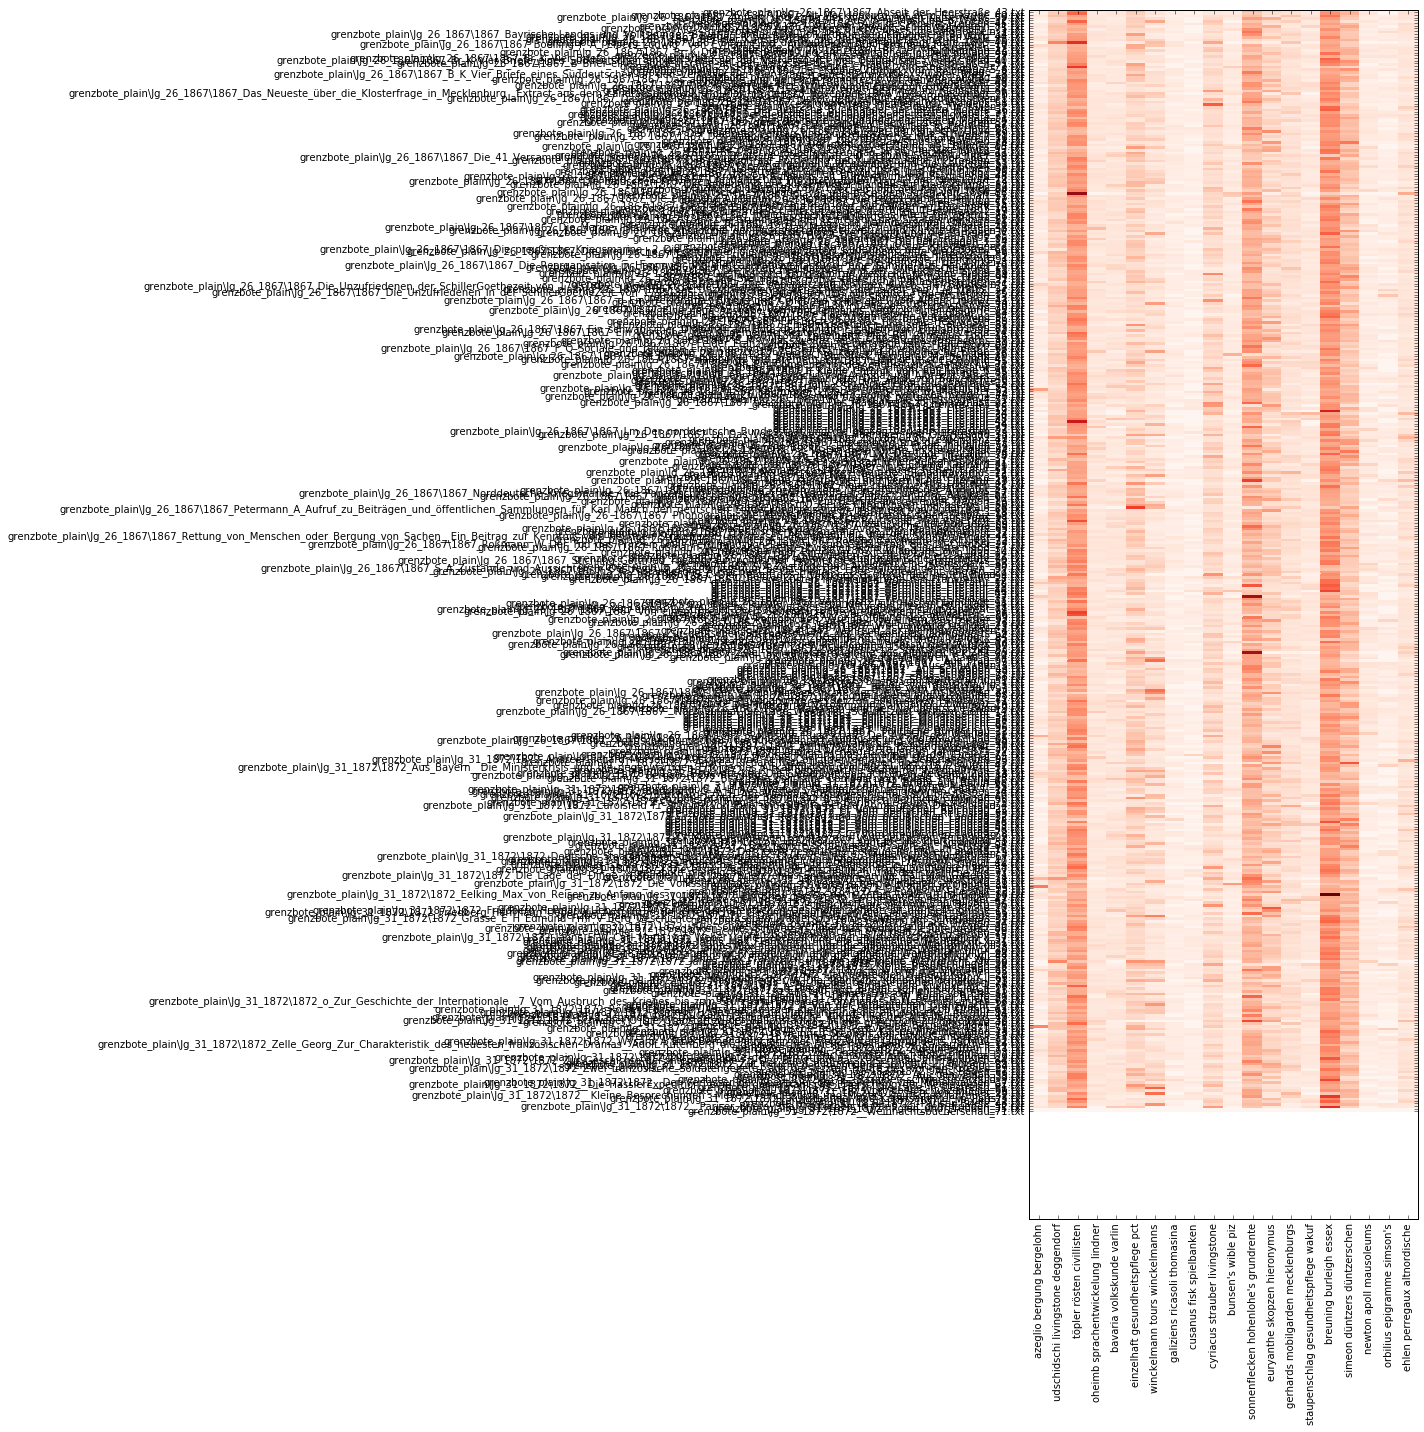

In [194]:
%matplotlib inline
visual.doc_topic_heatmap(doc_topic)

##### Visualize topic distribution in a single document

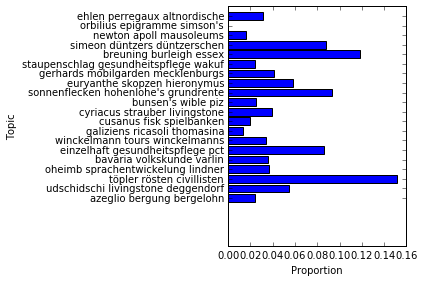

In [195]:
visual.plot_doc_topics(doc_topic, 0)

![success](http://cdn2.hubspot.net/hub/128506/file-446943132-jpg/images/computer_woman_success.jpg)